<a href="https://colab.research.google.com/github/AnastasiaButus/Interpolation-of-logging-curves/blob/main/Convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.signal import convolve
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Функция для применения низкочастотного фильтра с использованием свертки
def apply_low_pass_filter(signal, cutoff_frequency, sample_rate):
    """
    Применяет низкочастотный фильтр, используя свертку с функцией sinc.

    :param signal: Входной сигнал.
    :param cutoff_frequency: Частота среза низкочастотного фильтра.
    :param sample_rate: Частота дискретизации сигнала.

    :return: Отфильтрованный сигнал.
    """
    # Определяем длину фильтра
    filter_length = int(sample_rate / cutoff_frequency) * 10

    # Убеждаемся, что длина фильтра нечетная
    if filter_length % 2 == 0:
        filter_length += 1

    # Генерируем временной массив
    t = np.arange(-filter_length // 2, filter_length // 2 + 1)

    # Создаем фильтр sinc
    sinc_filter = np.sinc(2 * cutoff_frequency * t / sample_rate)

    # Применяем оконную функцию к фильтру sinc для уменьшения осцилляций Гиббса
    window = np.hamming(len(sinc_filter))
    sinc_filter *= window

    # Нормализуем фильтр
    sinc_filter /= np.sum(sinc_filter)

    # Применяем фильтр к сигналу с помощью свертки
    filtered_signal = convolve(signal, sinc_filter, mode='same')

    return filtered_signal

In [ ]:
# Загружаем данные из файлов
data = pd.read_excel('Proc_signal_BK.xlsx')
wells_data = pd.read_excel('Wells_info.xlsx')

In [ ]:
# Сопоставляем значения скорости (v) из Wells_info с колонками в Proc_signal_BK
v_values = wells_data.set_index('Well')['v, м/с'].to_dict()

In [ ]:
# Приблизительно определяем частоту дискретизации (исходя из предположения, что глубина равномерно дискретизирована)
depths = data.iloc[:, 0]
sample_rate = 1 / (depths[1] - depths[0])  # Предполагаем равномерные интервалы по глубине

In [ ]:
# Применяем низкочастотный фильтр к данным первых трех скважин для демонстрации
filtered_data = data.copy()  # Создаем копию для хранения отфильтрованных данных

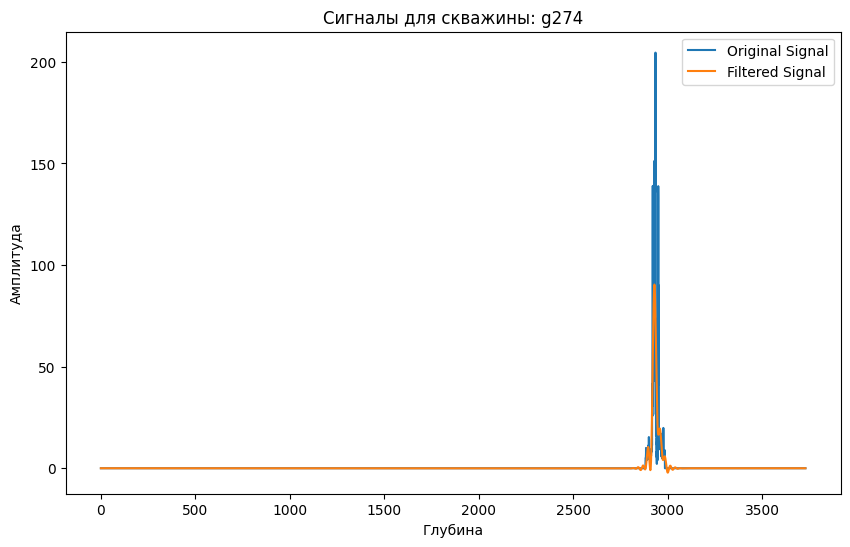

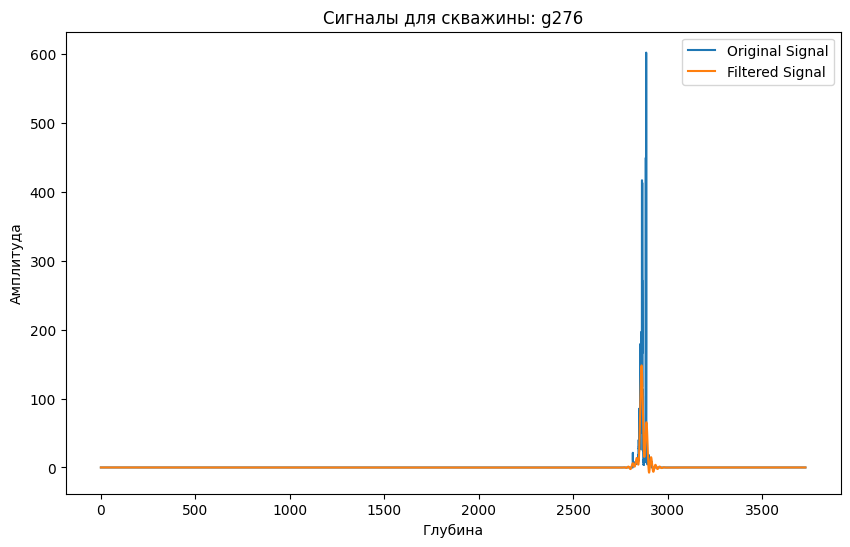

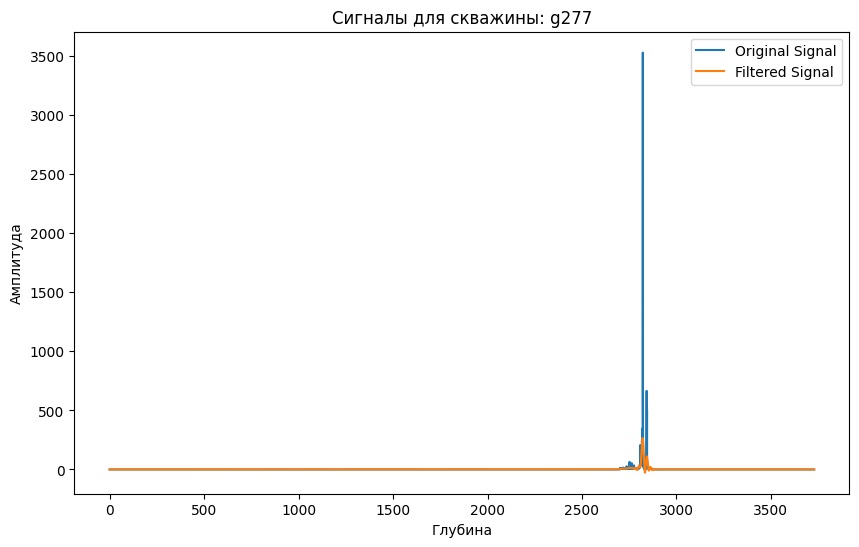

In [ ]:
# Фильтруем и строим графики для первых трех скважин
for column in data.columns[1:4]:
    if column in v_values:
        cutoff_frequency = 80 / v_values[column]
        signal = data[column].fillna(0)  # Заменяем NaN на 0 для фильтрации
        filtered_signal = apply_low_pass_filter(signal, cutoff_frequency, sample_rate)
        filtered_data[column] = filtered_signal

        # Строим графики исходных и отфильтрованных сигналов для сравнения
        plt.figure(figsize=(10, 6))
        plt.plot(depths, signal, label='Original Signal')
        plt.plot(depths, filtered_signal, label='Filtered Signal')
        plt.title(f'Сигналы для скважины: {column}')
        plt.xlabel('Глубина')
        plt.ylabel('Амплитуда')
        plt.legend()
        plt.show()

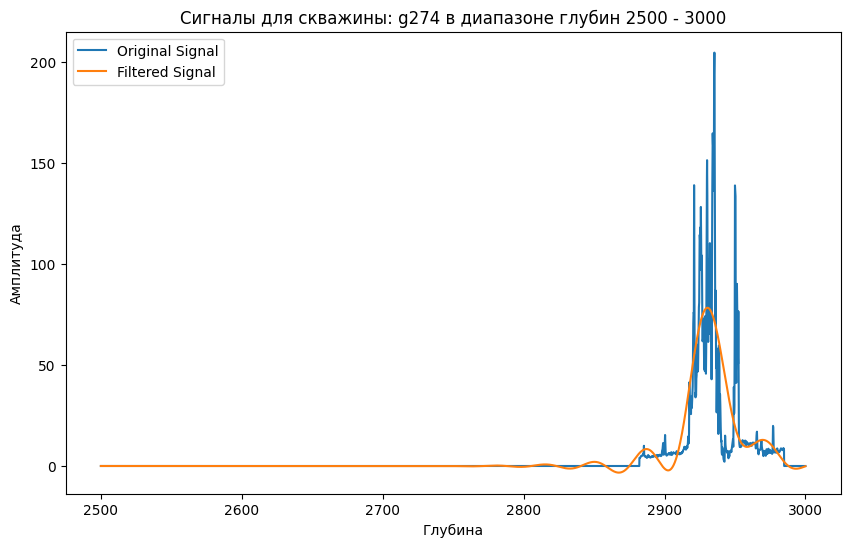

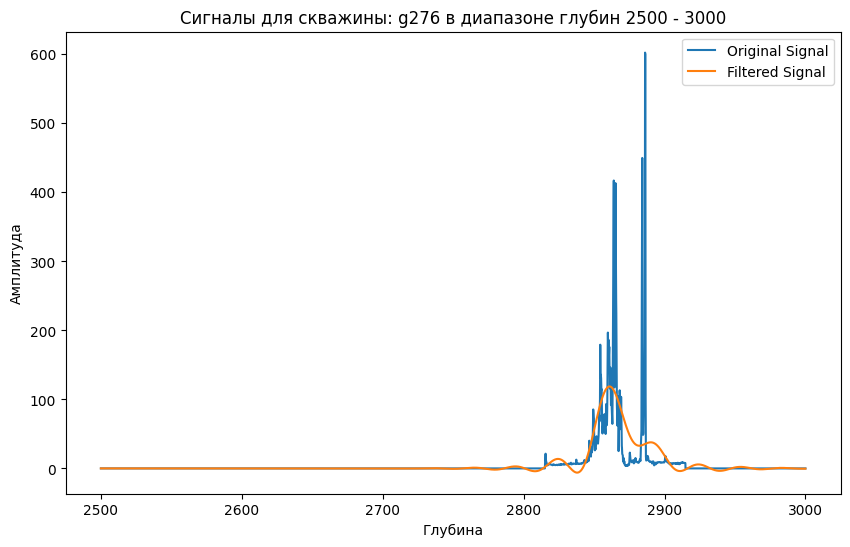

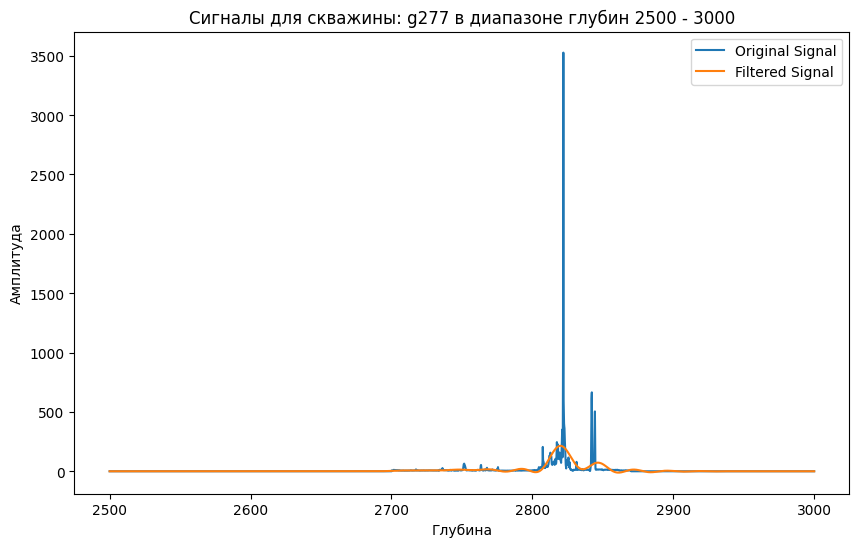

In [ ]:
def plot_filtered_data(depths, original_signal, filtered_signal, column, depth_range):
    """
    Функция для отображения графиков исходных и отфильтрованных сигналов в заданном диапазоне глубин.

    :param depths: Массив глубин.
    :param original_signal: Исходный сигнал.
    :param filtered_signal: Отфильтрованный сигнал.
    :param column: Название скважины (колонки).
    :param depth_range: Диапазон глубин для отображения (например, (2500, 3000)).
    """
    plt.figure(figsize=(10, 6))
    # Фильтруем данные по заданному диапазону глубин
    mask = (depths >= depth_range[0]) & (depths <= depth_range[1])
    plt.plot(depths[mask], original_signal[mask], label='Original Signal')
    plt.plot(depths[mask], filtered_signal[mask], label='Filtered Signal')
    plt.title(f'Сигналы для скважины: {column} в диапазоне глубин {depth_range[0]} - {depth_range[1]}')
    plt.xlabel('Глубина')
    plt.ylabel('Амплитуда')
    plt.legend()
    plt.show()

# Применяем низкочастотный фильтр и отображаем графики для первых трех скважин
for column in data.columns[1:4]:
    if column in v_values:
        cutoff_frequency = 60 / v_values[column]
        signal = data[column].fillna(0)  # Заменяем NaN на 0 для фильтрации
        filtered_signal = apply_low_pass_filter(signal, cutoff_frequency, sample_rate)
        filtered_data[column] = filtered_signal

        # Отображаем графики в диапазоне глубин 2500 - 3000
        plot_filtered_data(depths, signal, filtered_signal, column, (2500, 3000))


# **Трапеция Американо**

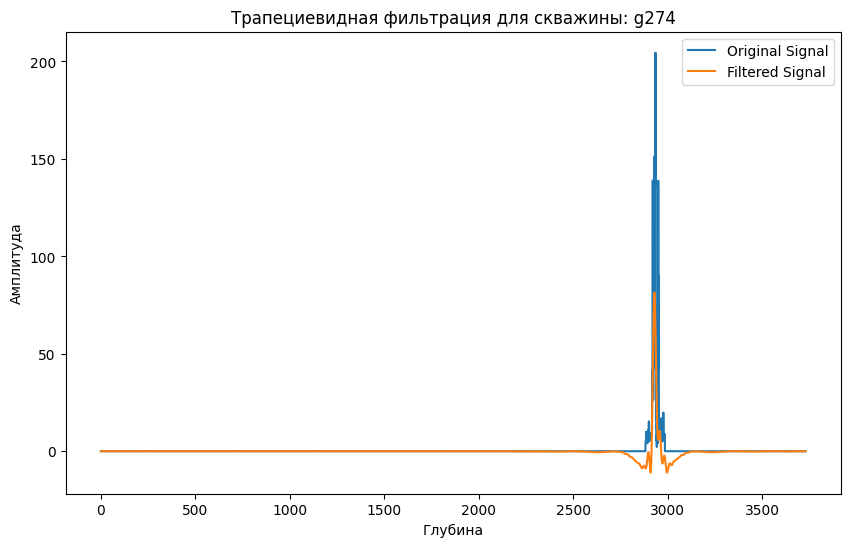

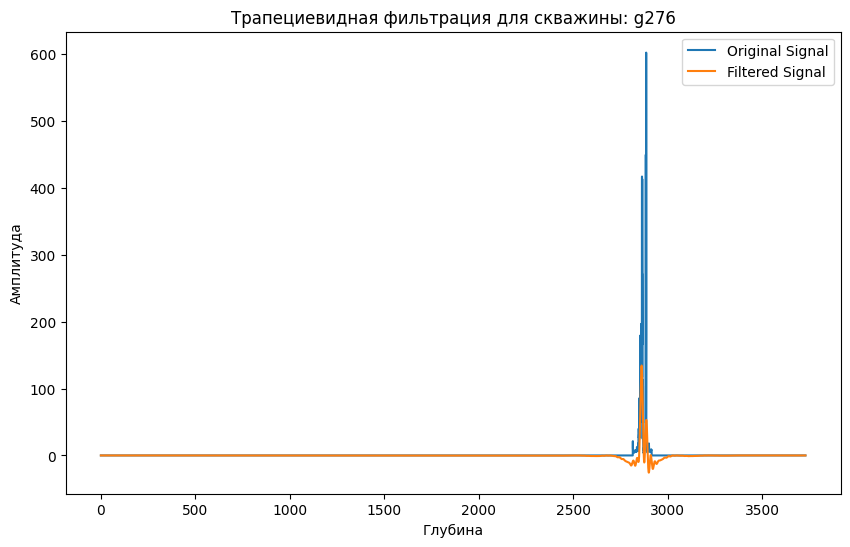

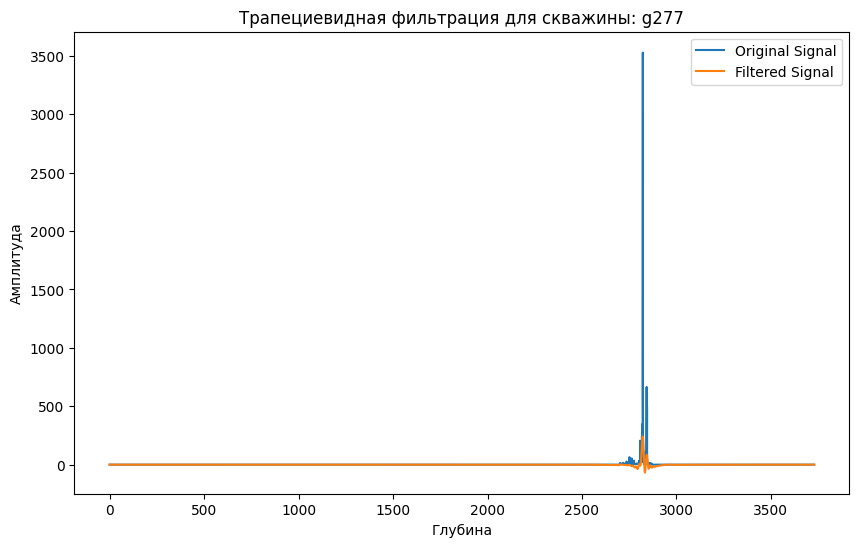

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
import pandas as pd

def apply_trapezoidal_filter(signal, sample_rate, v):
    """
    Применяет трапециевидный фильтр к сигналу.

    :param signal: Входной сигнал.
    :param sample_rate: Частота дискретизации сигнала.
    :param v: Скорость, используемая для определения границ фильтра.
    """
    # Определение частот для границ трапеции
    f0, f1, f2, f3 = 0, 10/v, 75/v, 95/v

    # Создание частотного массива
    freqs = np.fft.rfftfreq(len(signal), d=1/sample_rate)

    # Создание трапециевидной функции фильтра
    filter_values = np.zeros_like(freqs)
    np.clip((freqs - f0) / (f1 - f0), 0, 1, out=filter_values, where=(freqs >= f0) & (freqs <= f1))
    np.clip((f3 - freqs) / (f3 - f2), 0, 1, out=filter_values, where=(freqs >= f2) & (freqs <= f3))
    filter_values[(freqs > f1) & (freqs < f2)] = 1

    # Применение фильтра
    signal_fft = np.fft.rfft(signal)
    filtered_signal_fft = signal_fft * filter_values
    filtered_signal = np.fft.irfft(filtered_signal_fft, n=len(signal))

    return filtered_signal

# Применение трапециевидного фильтра к данным и визуализация результатов
for column in data.columns[1:4]:
    if column in v_values:
        signal = data[column].fillna(0)  # Заменяем NaN на 0 для фильтрации
        filtered_signal = apply_trapezoidal_filter(signal, sample_rate, v_values[column])
        filtered_data[column] = filtered_signal

        # Строим графики исходных и отфильтрованных сигналов для сравнения
        plt.figure(figsize=(10, 6))
        plt.plot(depths, signal, label='Original Signal')
        plt.plot(depths, filtered_signal, label='Filtered Signal')
        plt.title(f'Трапециевидная фильтрация для скважины: {column}')
        plt.xlabel('Глубина')
        plt.ylabel('Амплитуда')
        plt.legend()
        plt.show()


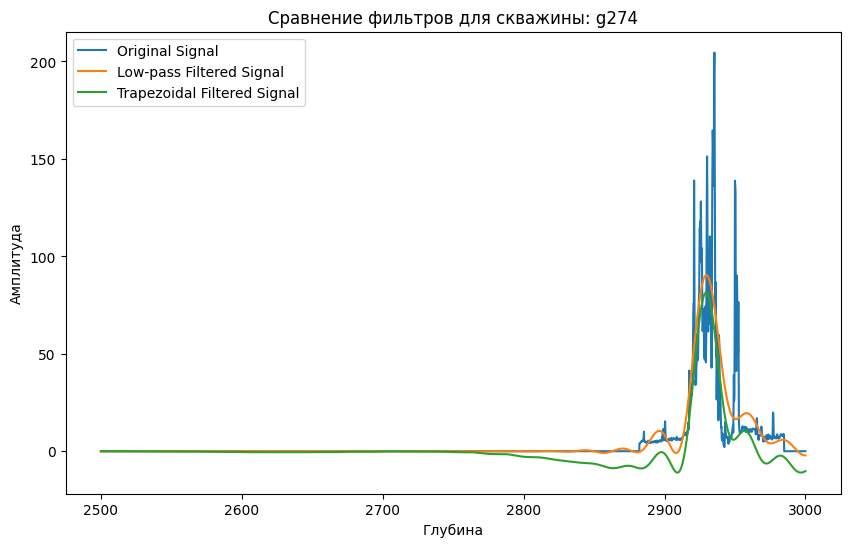

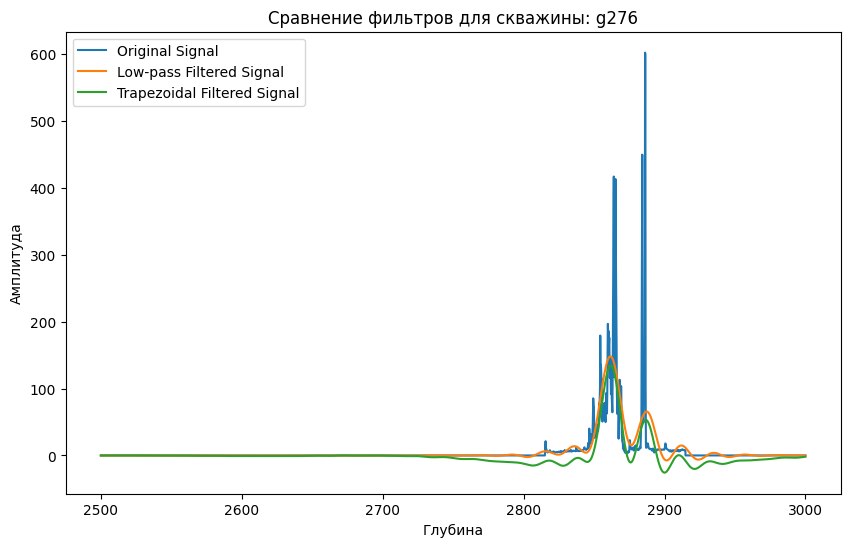

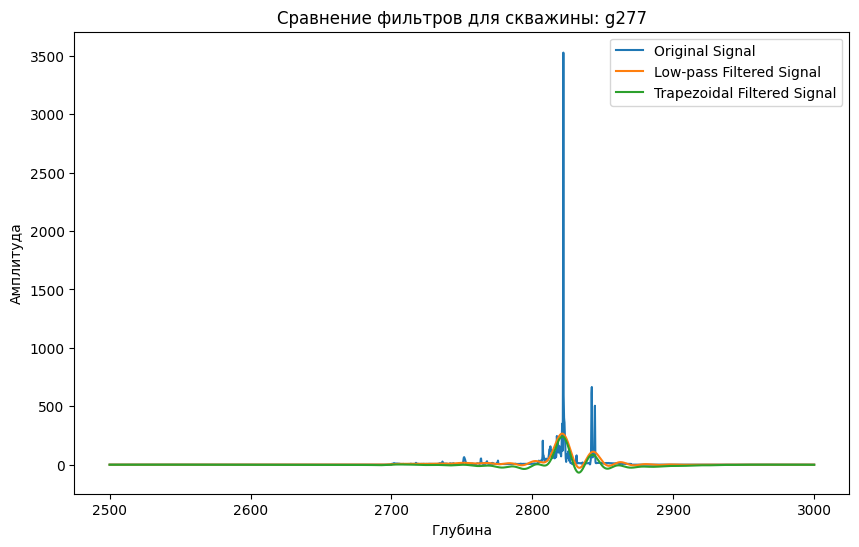

In [ ]:
def plot_filtered_signals(depths, signal, filtered_signal, title, depth_range):
    """
    Визуализирует сигналы в заданном диапазоне глубин.

    :param depths: Массив глубин.
    :param signal: Исходный сигнал.
    :param filtered_signal: Отфильтрованный сигнал.
    :param title: Заголовок графика.
    :param depth_range: Диапазон глубин для отображения.
    """
    mask = (depths >= depth_range[0]) & (depths <= depth_range[1])
    plt.figure(figsize=(10, 6))
    plt.plot(depths[mask], signal[mask], label='Original Signal')
    plt.plot(depths[mask], filtered_signal[mask], label='Filtered Signal')
    plt.title(title)
    plt.xlabel('Глубина')
    plt.ylabel('Амплитуда')
    plt.legend()
    plt.show()

def compare_filters(depths, original_signal, low_pass_signal, trapezoidal_signal, title, depth_range):
    """
    Сравнивает результаты двух фильтров в заданном диапазоне глубин.

    :param depths: Массив глубин.
    :param original_signal: Исходный сигнал.
    :param low_pass_signal: Сигнал после низкочастотной фильтрации.
    :param trapezoidal_signal: Сигнал после трапециевидной фильтрации.
    :param title: Заголовок графика.
    :param depth_range: Диапазон глубин для отображения.
    """
    mask = (depths >= depth_range[0]) & (depths <= depth_range[1])
    plt.figure(figsize=(10, 6))
    plt.plot(depths[mask], original_signal[mask], label='Original Signal')
    plt.plot(depths[mask], low_pass_signal[mask], label='Low-pass Filtered Signal')
    plt.plot(depths[mask], trapezoidal_signal[mask], label='Trapezoidal Filtered Signal')
    plt.title(title)
    plt.xlabel('Глубина')
    plt.ylabel('Амплитуда')
    plt.legend()
    plt.show()

# Пример использования функций для визуализации и сравнения фильтров
for column in data.columns[1:4]:
    if column in v_values:
        signal = data[column].fillna(0)
        low_pass_signal = apply_low_pass_filter(signal, 80 / v_values[column], sample_rate)
        trapezoidal_signal = apply_trapezoidal_filter(signal, sample_rate, v_values[column])
        compare_filters(depths, signal, low_pass_signal, trapezoidal_signal, f'Сравнение фильтров для скважины: {column}', (2500, 3000))


# **Чекаем спектр **

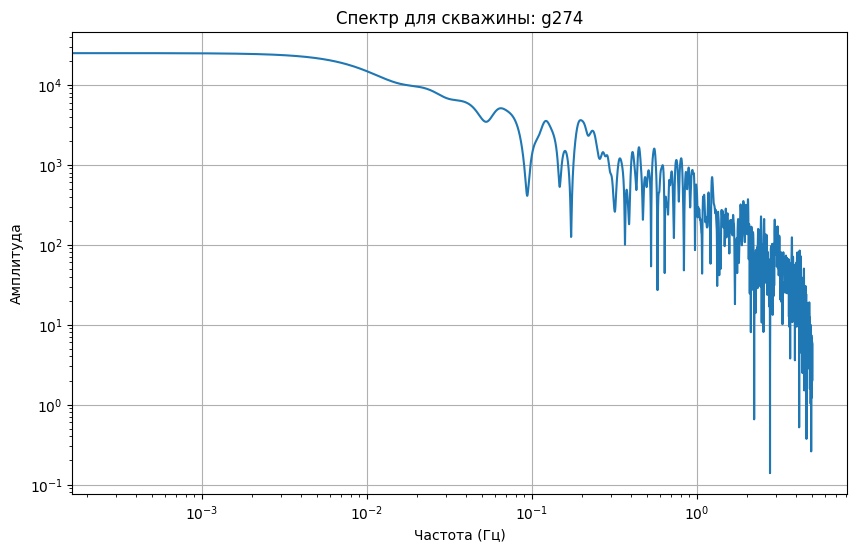

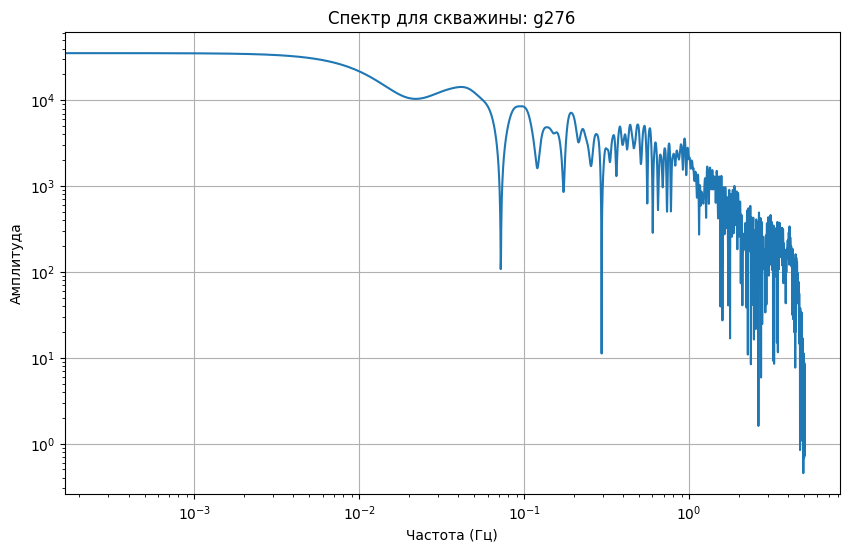

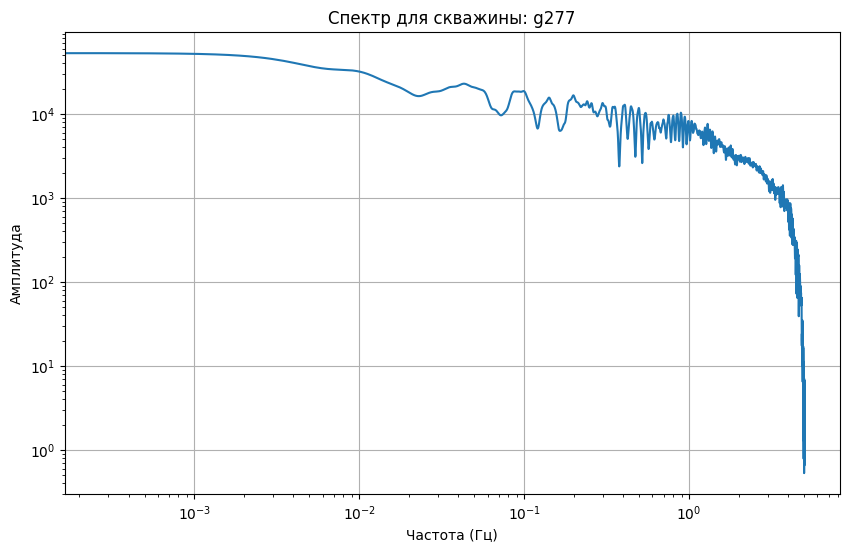

In [ ]:
def plot_signal_spectrum(signal, sample_rate, title):
    """
    Визуализирует спектр сигнала.

    :param signal: Сигнал для анализа.
    :param sample_rate: Частота дискретизации сигнала.
    :param title: Заголовок графика.
    """
    fft_result = np.fft.rfft(signal)
    frequencies = np.fft.rfftfreq(len(signal), d=1/sample_rate)

    plt.figure(figsize=(10, 6))
    plt.plot(frequencies, np.abs(fft_result))
    plt.title(title)
    plt.xlabel('Частота (Гц)')
    plt.ylabel('Амплитуда')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

# Пример визуализации спектра для первых нескольких колонок данных
for column in data.columns[1:4]:  # Показываем спектры для первых трех колонок
    if column in v_values:
        signal = data[column].fillna(0)  # Заменяем NaN на 0
        plot_signal_spectrum(signal, sample_rate, f'Спектр для скважины: {column}')
